In [1]:
import pandas as pd
from pathlib import Path

In [2]:
import time
from datetime import datetime

#measure notebook running time
start_time = time.time()

%matplotlib inline

import os, warnings
import numpy as np 
from numpy.random import seed
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import metrics
import tensorflow as tf
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, precision_score,recall_score, f1_score, classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import MEstimateEncoder

sns.set(style='white', context='notebook', palette='deep', rc={'figure.figsize':(10,8)})
print("loaded ...")


2025-08-18 23:30:41.233541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755559841.248416       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755559841.252829       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-18 23:30:41.271563: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/usr/local/lib/python3.11/dist-packages/sklearn/metrics/__init__.py)

In [3]:
# Reproducibility
def set_seed(sd):
    seed(sd)
    np.random.seed(sd)
    tf.random.set_seed(sd)
    os.environ['PYTHONHASHSEED'] = str(sd)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
RandomSeed = 13
set_seed(RandomSeed)


In [4]:
train_data = pd.read_csv('/kaggle/input/tabular-playground-series-may-2022/train.csv')
test_data = pd.read_csv('/kaggle/input/tabular-playground-series-may-2022/test.csv')
test_data['target'] = -1
train_data['Set'] = "Train"
test_data['Set'] = "Test"
DATA = train_data.append(test_data)
DATA.reset_index(inplace=True)
DATA.info()


AttributeError: 'DataFrame' object has no attribute 'append'

In [5]:
features = [f for f in DATA.columns if "f_" in f]
float_features = [f for f in features if DATA[f].dtype == "float64"]
int_features = [f for f in features if DATA[f].dtype == "int64"]
str_features = [f for f in features if DATA[f].dtype == "object"]


NameError: name 'DATA' is not defined

In [6]:
DATA[int_features].describe()


NameError: name 'DATA' is not defined

In [7]:
DATA[float_features].describe()


NameError: name 'DATA' is not defined

In [8]:
scaler = MinMaxScaler()
DATA[[*float_features,*int_features]] = scaler.fit_transform(DATA[[*float_features,*int_features]])


NameError: name 'DATA' is not defined

In [9]:
def plot_hist(features, title):
    N_cols = 4
    col_width = 8
    N_rows = round(len(features) / N_cols + 0.49)
    fig, axs = plt.subplots(nrows = N_rows, ncols=N_cols, figsize=(col_width * N_cols, N_rows * col_width))
    for i,f in enumerate(features):
        axs[i//N_cols, i%N_cols].hist(DATA[DATA.Set == 'Train'][f], bins=20);
        axs[i//N_cols, i%N_cols].set_title(f)
        axs[i//N_cols, i%N_cols].legend();


In [10]:
%%time
plot_hist(float_features, 'float_features')


NameError: name 'float_features' is not defined

In [11]:
%%time
plot_hist(int_features, 'int_features')


NameError: name 'int_features' is not defined

NameError: name 'DATA' is not defined

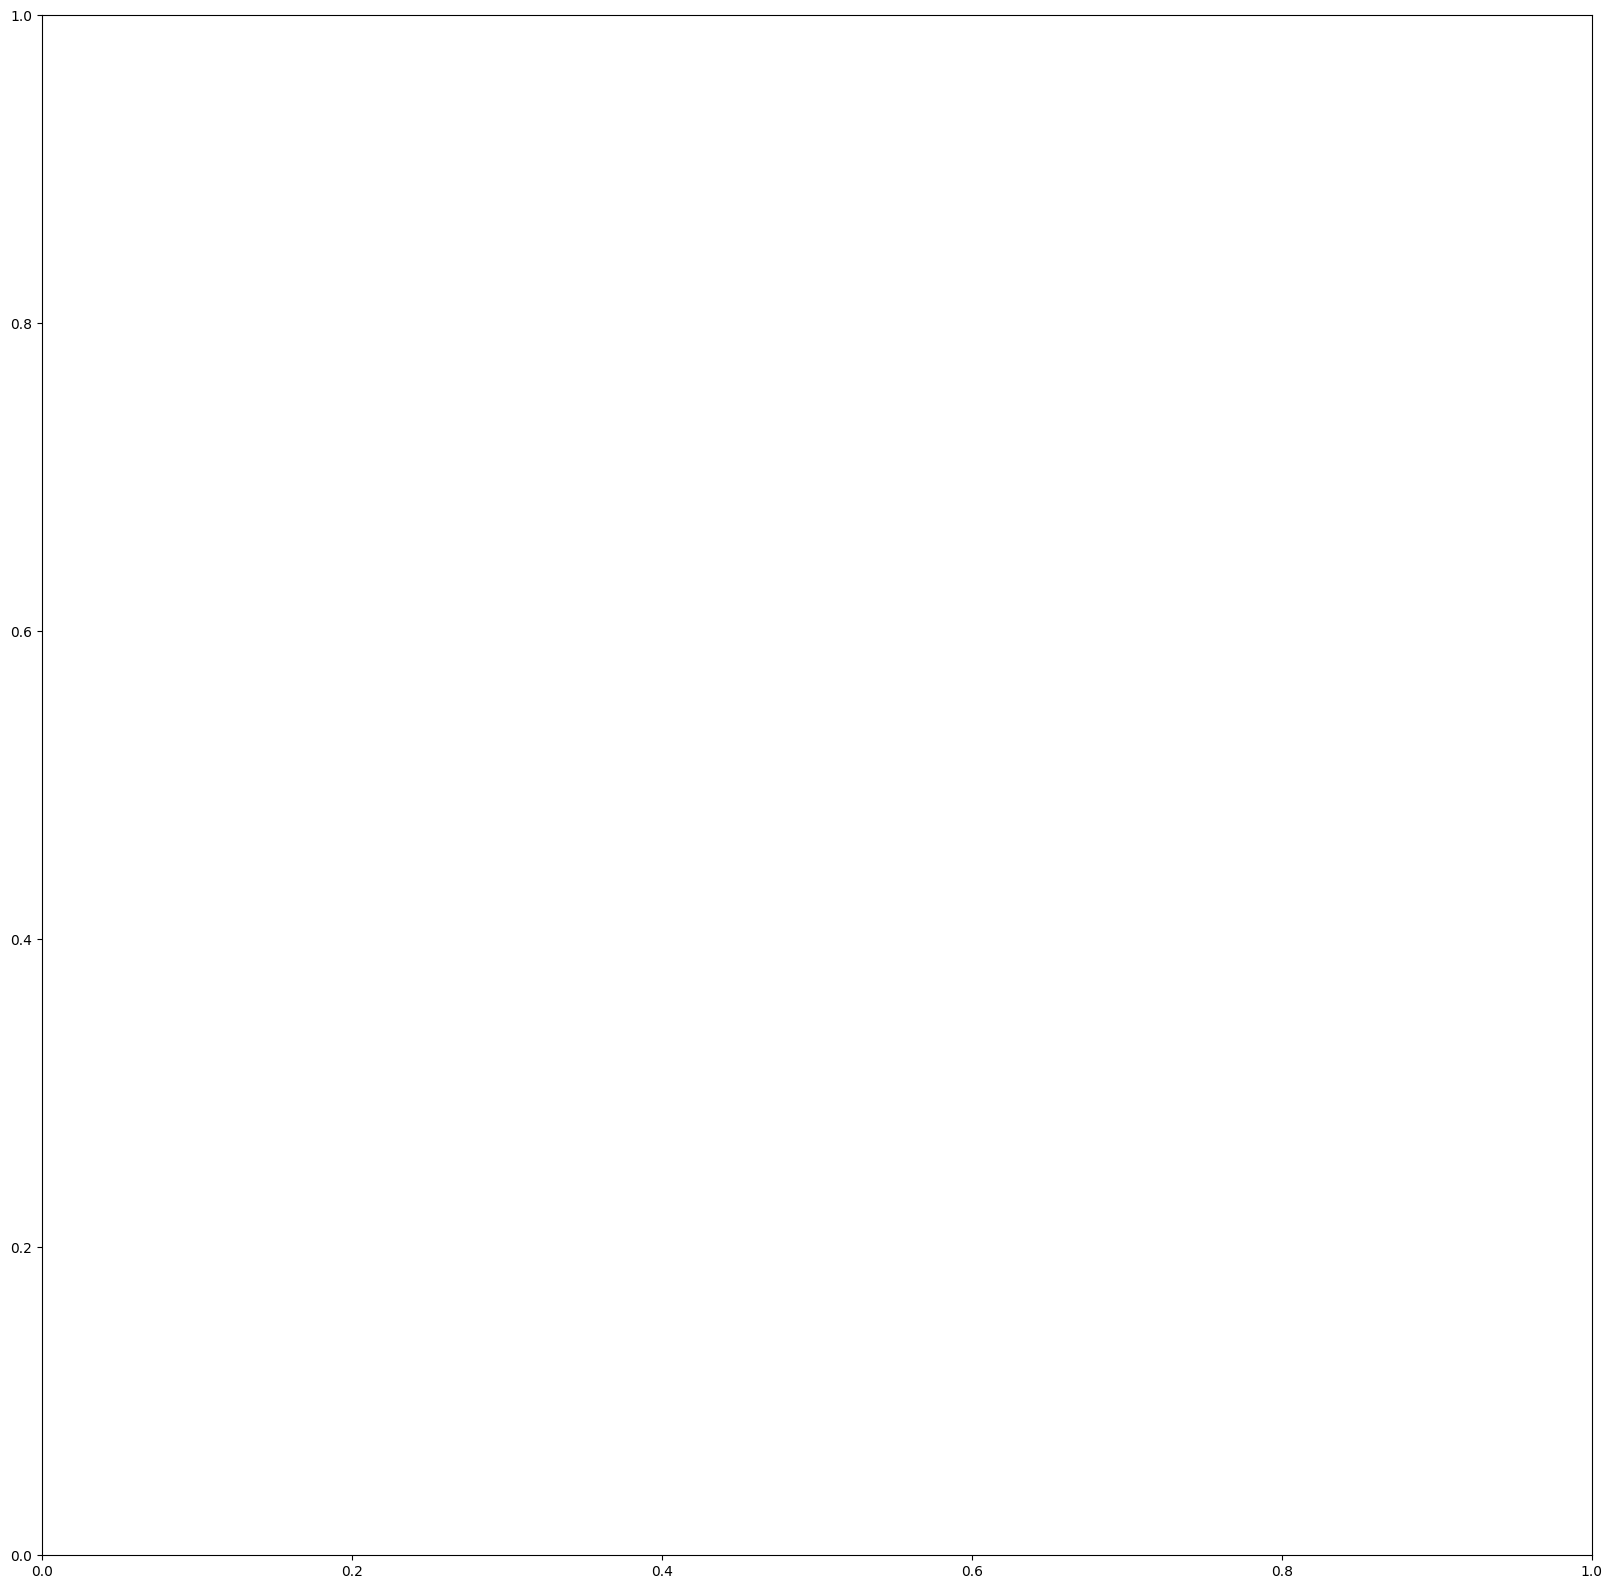

In [12]:
fig, ax = plt.subplots(figsize=(20,20)) 
ax = sns.heatmap(DATA[DATA.Set == 'Train'][[*int_features,'target']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm");
ax.set_title("Target -  correlation to int features");


NameError: name 'DATA' is not defined

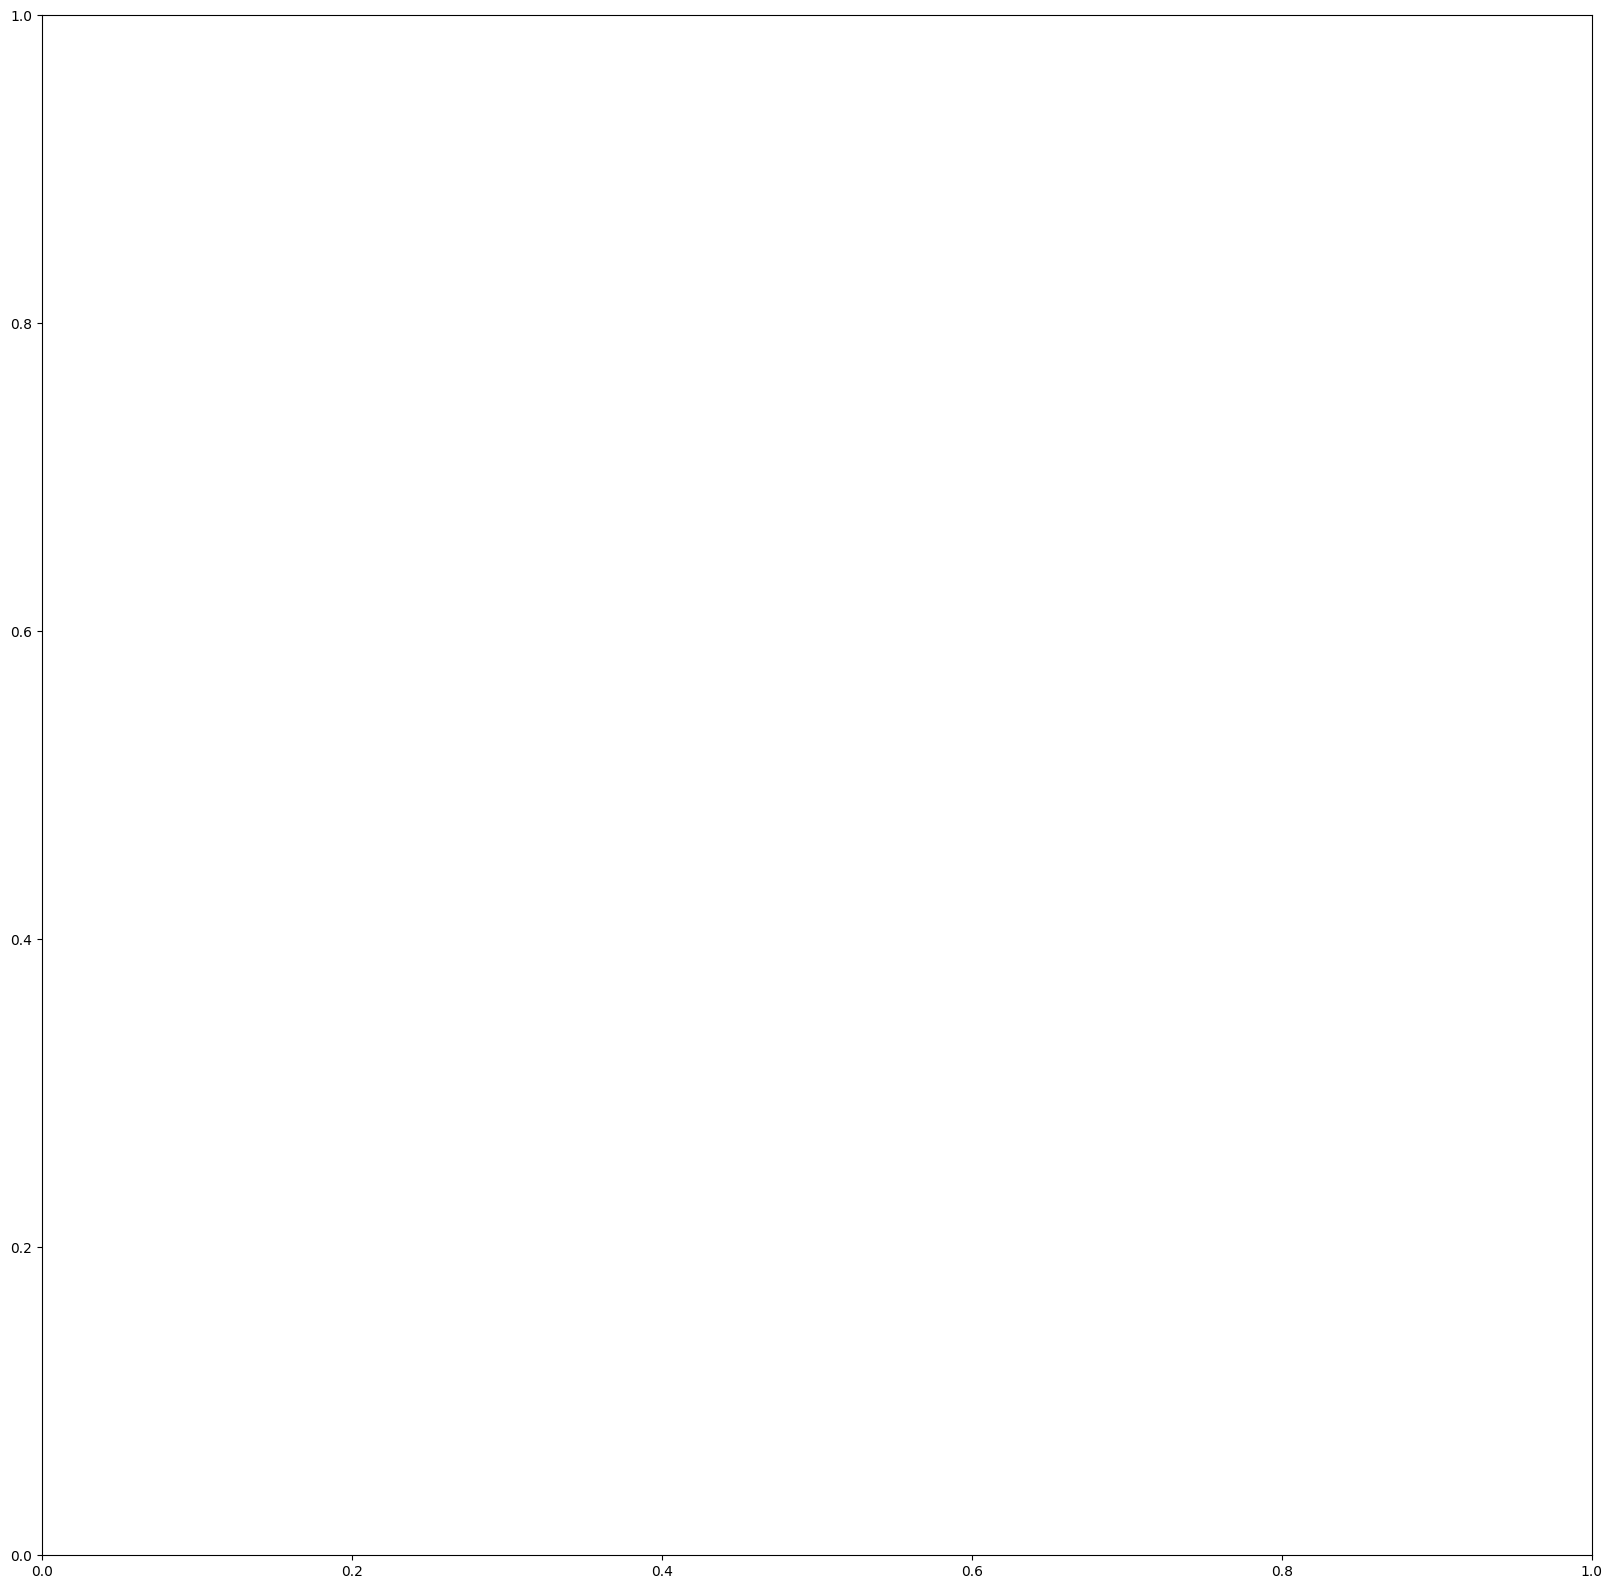

In [13]:
fig, ax = plt.subplots(figsize=(20,20)) 
ax = sns.heatmap(DATA[DATA.Set == 'Train'][[*float_features,'target']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm");
ax.set_title("Target -  correlation to float features");


In [14]:
# pca = PCA(2)
# X_PCA = pca.fit_transform(DATA.loc[:, [*float_features, *int_features]])
# PCA_component_names = [f"PC{i+1}" for i in range(X_PCA.shape[1])]
# X_PCA = pd.DataFrame(X_PCA, columns=PCA_component_names)
# X_PCA.head()


In [15]:
# DATA_PCA = X_PCA.copy()
# DATA_PCA['target'] = DATA['target']
# DATA_PCA=DATA_PCA[DATA_PCA['target'] != -1]
# pca.explained_variance_ratio_


In [16]:
# %%time
# sns.scatterplot(data = DATA_PCA, x = "PC1", y= "PC2", hue = 'target');


In [17]:
# fig, axs = plt.subplots(1, 2)
# n = pca.n_components_
# grid = np.arange(1, n + 1)
# # Explained variance
# evr = pca.explained_variance_ratio_
# axs[0].bar(grid, evr)
# axs[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))
# # Cumulative Variance
# cv = np.cumsum(evr)
# axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
# axs[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))
# # Set up figure
# fig.set(figwidth=8, dpi=100);


In [18]:
# loadings = pd.DataFrame(
#         pca.components_.T,  # transpose the matrix of loadings
#         columns=PCA_component_names,  # so the columns are the principal components
#         index=DATA.loc[:, [*float_features, *int_features]].columns,  # and the rows are the original features
#     )
# loadings


In [19]:
# MELT = pd.melt(DATA[DATA.Set == 'Train'][[*float_features,*int_features,'target']], value_vars = [*float_features,*int_features],id_vars= 'target')
# MELT.head()


In [20]:
# %%time
# ax = sns.displot(MELT, x='value', hue='target', col='variable', kind='kde',col_wrap= 5);
# ax.set(xlim = (-10,10), ylim = (0, 0.05));


In [21]:
DATA[str_features].head()


NameError: name 'DATA' is not defined

In [22]:
# EXPLORE = pd.DataFrame()
# EXPLORE['String'] = DATA[str_features].copy()
# EXPLORE['len'] = EXPLORE['String'].apply(len)


In [23]:
TRAIN = DATA[DATA.Set == 'Train']
TEST = DATA[DATA.Set == 'Test'][[*float_features, *int_features]]
X = TRAIN[[*float_features, *int_features]]
y = TRAIN.target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = RandomSeed, stratify=y)


NameError: name 'DATA' is not defined

In [24]:
def CM(y_test, val_pred, title):
    labels = [0,1]
    cm = confusion_matrix(y_test, val_pred, normalize = 'pred')
    cm_train = confusion_matrix(y_train, train_pred, normalize = 'pred')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,8))
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels= labels);
    disp_train.plot(ax=ax1, values_format='.1%', xticks_rotation='horizontal');
    disp_train.ax_.set_title('Train set', {'fontsize':20});

    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= labels);
    disp_test.plot(ax=ax2, values_format='.1%', xticks_rotation='horizontal');
    disp_test.ax_.set_title('Validation set',{'fontsize':20});
    fig.suptitle(title, fontsize=16);
    
def IMP(model, label, columns = X_train.columns):
    features = {}
    for feature, importance in zip(columns, model.feature_importances_):
        features[feature] = importance

    importances = pd.DataFrame({label:features})
    importances.sort_values(label, ascending = True, inplace=True)
    importances[:10].plot.barh()


NameError: name 'X_train' is not defined

In [25]:
rf_params = {
    'n_jobs':-1,
    'random_state': RandomSeed,
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'auto',
    'max_samples': None
}


In [26]:
rf_grid = {
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf':[1],
    'max_features': ['auto'],
    'max_samples': [None, 0.9],
    'n_estimators': [100],
}


In [27]:
# %%time
# rf_clf = RandomForestClassifier(**rf_params)
# rf_grid_clf = GridSearchCV(rf_clf, rf_grid, cv=3, scoring= "f1_micro")
# rf_grid_clf.fit(X_train, y_train)
# print(rf_grid_clf.best_estimator_)
# print(rf_grid_clf.best_params_)
# print(rf_grid_clf.best_score_)


In [28]:
# print("Reference score:",0.8214888888888888, 
#       "{'max_depth': None, 'max_features': 'auto', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",
#       "\n")

# rf_scores = pd.DataFrame(rf_grid_clf.cv_results_['params'])
# rf_scores['results'] = rf_grid_clf.cv_results_['mean_test_score']
# rf_scores['std'] = rf_grid_clf.cv_results_['std_test_score']
# rf_scores = rf_scores.sort_values('results', ascending=False)
# rf_scores


In [29]:
%%time
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train, y_train)
rf_train_score = rf_model.score(X_train, y_train)
rf_accuracy = rf_model.score(X_test, y_test)
print("Train: {:.2f} %".format(rf_train_score * 100))
print("Test: {:.2f} %".format(rf_accuracy*100))
print('Overfit: {:.2f} %'.format((rf_train_score-rf_accuracy)*100))


NameError: name 'X_train' is not defined

In [30]:
%%time
train_pred = rf_model.predict(X_train)
val_pred = rf_model.predict(X_test)
print(classification_report(y_test, val_pred))


NameError: name 'X_train' is not defined

In [31]:
CM(y_test, val_pred, 'Random Forest Classifier')


NameError: name 'y_test' is not defined

In [32]:
IMP(rf_model, "RF")


NameError: name 'IMP' is not defined

In [33]:
print("Accuracy Scores:")
print("==========================================================")
# print("DNN: {:.3f}".format(dnn_accuracy))
print("RandomForest: {:.3f}".format(rf_accuracy))
# print("XGBoost classifier: {:.3f}".format(xgb_accuracy))
# print("SVM classifier: {:.3f}".format(SVM_accuracy))
# print("LR classifier: {:.3f}".format(LR_accuracy))
# print("KNN classifier: {:.3f}".format(KNN_accuracy))
# print("ADA Boost classifier: {:.3f}".format(ADA_accuracy))
# print("Extra Tree classifier: {:.3f}".format(ETC_accuracy))
# print("Gradient Boosting classifier: {:.3f}".format(GBC_accuracy))
# print("Stochastic Gradient descent: {:.3f}".format(SGD_accuracy))
# print("Decision Tree classifier: {:.3f}".format(DT_accuracy))
# print("LGBM classifier: {:.3f}".format(LGBM_accuracy))
#print("FLAML classifier: {:.3f}".format(flaml_accuracy))
print("==========================================================")


Accuracy Scores:


NameError: name 'rf_accuracy' is not defined

In [34]:
models = [rf_model]
model_names = ["RF"]
print("using", len(models), "classifiers")


using 1 classifiers


In [35]:
%%time
SVC_ALL_PREDICTIONS = pd.DataFrame({'id': DATA[DATA.Set == 'Test']['id']})
for i, m in enumerate(models):
    SVC_ALL_PREDICTIONS[model_names[i]] = m.predict_proba(TEST)[:,1]
SVC_ALL_PREDICTIONS['MedianVote'] = SVC_ALL_PREDICTIONS[model_names].median(axis=1)
SVC_ALL_PREDICTIONS['SoftVote'] = SVC_ALL_PREDICTIONS[model_names].mean(axis=1)
#SVC_ALL_PREDICTIONS['Predict'] = SVC_ALL_PREDICTIONS.SoftVote.apply(lambda row: 1 if row > TRESHOLD else 0)
svc_predictions = SVC_ALL_PREDICTIONS.SoftVote
SVC_ALL_PREDICTIONS.head(10)


NameError: name 'DATA' is not defined

In [36]:
# fig, ax = plt.subplots(figsize=(12,12))  
# g= sns.heatmap(SVC_ALL_PREDICTIONS[model_names].corr(),annot=True, cmap = "coolwarm")


In [37]:
output = pd.DataFrame({'id': DATA[DATA.Set == 'Test']['id'], 'target': svc_predictions})
output.head(10)


NameError: name 'DATA' is not defined

In [38]:
#output
output.to_csv('submission.csv', index=False)
print("Submission was successfully saved!")


NameError: name 'output' is not defined

In [39]:
end_time = time.time()
print("Notebook run time: {:.1f} seconds. Finished at {}".format(end_time - start_time, datetime.now()) )


Notebook run time: 11.0 seconds. Finished at 2025-08-18 23:30:51.438871
